import packages

In [1]:
import glob
import os

# data/plot management
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import warnings

# plotting/mapmaknig
import geopandas as gpd
from geospatial_functions import get_background_map
import rasterio
from rasterio.plot import show as rioshow
import folium

# adding 'custom script' 
#Ensure the [Pyeto](https://github.com/woodcrafty/PyETo) package is present in your 
# "C:\Users\{USERNAME}\anaconda3\envs\{ENVIRONMENT}\Lib\",or "C:\Users\{USERNAME}\anaconda3\Lib\",
from pyeto import thornthwaite, monthly_mean_daylight_hours, deg2rad

from scipy.optimize import root

warnings.simplefilter('ignore')

add some useful paths to navigate shared storage:

In [2]:
path = os.getcwd()
home_path = os.path.dirname(path)
main_folder = os.path.dirname(home_path)

gis_folder = f'{main_folder}\\QGIS project'

add some spatial data

In [3]:
country_outline = gpd.read_file(f"{gis_folder}\\country_outline_32630.gpkg")
volta_outline = gpd.read_file(f"{gis_folder}\\volta_watershed_vector_32630.gpkg",crs="epsg:32630")
main_rivers = gpd.read_file(f"{gis_folder}\\main_rivers_volta.gpkg",crs="epsg:32630")

country_outline = country_outline.set_geometry(country_outline.geometry.to_crs('EPSG:4326'))
volta_outline = volta_outline.set_geometry(volta_outline.geometry.to_crs('EPSG:4326'))
main_rivers = main_rivers.set_geometry(main_rivers.geometry.to_crs('EPSG:4326'))

gdf_precip = gpd.read_file('precipitation_data_client.geojson',crs="EPSG:4326")
gdf_discharge_client = gpd.read_file('discharge_data_client.geojson',crs="EPSG:4326")
gdf_discharge_client['name'] = gdf_discharge_client.apply(lambda x: x['name'].split(",")[-1][:-4].strip().lower(),axis=1)

In [4]:
gdf_discharge_client

,name,lat,lon,geometry
0,vonkoro,9.171205,-2.744841,POINT (-2.74484 9.17121)
1,dan,10.867876,-3.722479,POINT (-3.72248 10.86788)
2,samandeni,11.458715,-4.469477,POINT (-4.46948 11.45872)
3,dapola,10.572862,-2.914135,POINT (-2.91413 10.57286)
4,yakala,11.344608,-0.528965,POINT (-0.52897 11.34461)
5,yilou,12.999710,-1.570603,POINT (-1.57060 12.99971)
6,dakaye,11.777456,-1.600156,POINT (-1.60016 11.77746)
7,porga,11.045433,0.959914,POINT (0.95991 11.04543)
8,samboali,11.279537,1.015889,POINT (1.01589 11.27954)


# make general:

#### load precipitation data from analysis

In [5]:
Rainfall_BF_msum = pd.read_excel("Monthly_sum_rainfall.xlsx",index_col=0)
Rainfall_BF_msum.columns

Index(['Ouagadougou', 'Nakambe', 'Black_Volta', 'Mouhoun', 'Lake_Volta', 'Oti',
       'Penjari'],
      dtype='object')

#### load discharge data from analysis

In [6]:
names = ['black volta, vonkoro',
         'bougouriba, dan',
         'mou houn, black volta, samandeni',
         'mou houn, black volta,dapola',
         'nakanbe, white volta, yakala',
         'nakanbe, white volta, yilou',
         'nazinon, red volta, dakaye',
         'pendjari, porga',
         'singou, samboali']

need a dictionary to link discharge to precipitation stations

In [7]:
q_p_linking_dictionary = {'black volta, vonkoro': 'Black_Volta',
                          'bougouriba, dan': 'Mouhoun',
                          'mou houn, black volta, samandeni': 'Mouhoun',
                          'mou houn, black volta,dapola': 'Black_Volta',
                          'nakanbe, white volta, yakala': 'Nakambe',
                          'nakanbe, white volta, yilou': 'Nakambe',
                          'nazinon, red volta, dakaye': 'Nakambe',
                          'pendjari, porga': 'Penjari',
                          'singou, samboali': 'Penjari'}

In [8]:
df_discharge_per_location_lst = []
for name in names:
    df_discharge = pd.read_excel(f"{home_path}\\Combining data\\{name}.xlsx",index_col=0)
    df_discharge_per_location_lst.append(df_discharge)

## E

historic temperature data downloaded from [CMIP6](https://storage.googleapis.com/cmip6/pangeo-cmip6.json) model from NOAA-GFDL - 

In [9]:
df_temperature = pd.read_excel(f"{home_path}\\Evaporation\\daily_Near-Surface-Air-Temperature.xlsx",
# df_temperature = pd.read_excel(f"{home_path}\\Evaporation\\mean_monthly_Near-Surface-Air-Temperature.xlsx",
                       index_col=0, parse_dates=True)
df_temperature.rename(columns={0:"Temperature"},inplace=True)
df_temperature_msum = df_temperature.resample('M').mean()

`dakaye` was chosen to as fairly centrally located

In [10]:
lat = deg2rad(gdf_discharge_client[gdf_discharge_client['name']=="dakaye"].iloc[0].geometry.y)

In [11]:
years = df_temperature_msum.index.year.unique()
for year in years:
    mmdlh = monthly_mean_daylight_hours(lat, year)
    # use thornthwaite to calculate the 
    evap = thornthwaite(df_temperature_msum[f'{year}'].Temperature.to_list(), mmdlh, year=year)
    set_items = df_temperature_msum[f'{year}'].index
    df_temperature_msum.loc[set_items,"evap"] = evap

# some function

In [12]:
def plot_combined_df(combined_df):    
    """Plots the combined_dfs constructed"""
    fig, ax = plt.subplots(1)
    ax.set_xlabel("Date")
    ax.set_ylabel("$m^3/month$")
    for val in ["P","Q","E"]:
        combined_df[val].plot(marker='.',lw=0.5, ax=ax,label=val)

    combined_df["Diff"].plot(ax=ax,label="Difference")
    ax.get_xlim()
    ax.set_title(f"Water balance")
    ax.legend()
    ax.axhline(0, alpha=0.2, ls="--", color="C4" )

In [13]:
FACTOR_EA_EP = 0.2726

In [14]:
output_river = main_rivers.copy()

# now run per river segment:

In [15]:
for index, row in main_rivers.iterrows():
    # get the centre of each segment
    centre = row.geometry.centroid
    # find nearest precipitation station:
    closest_station_index = gdf_precip.distance(centre).argmin()
    name_of_closest_station = gdf_precip.loc[closest_station_index, "name"]
    selected_rain_data = Rainfall_BF_msum[[name_of_closest_station]].rename(columns={name_of_closest_station:"P"})
    
    #prepare evaporation data
    df_temperature_msum.rename(columns={'evap':'E'},inplace=True)
    area_basin = row.UPLAND_SKM * 10**6
    
    # adjust potential to actuall evaporation
    combined_df = area_basin * FACTOR_EA_EP * df_temperature_msum[["E"]].copy()
    # combine everything:
    combined_df["P"] = selected_rain_data["P"] * area_basin
    combined_df["Q"] = combined_df["P"] - combined_df["E"]
    combined_df = combined_df.loc[combined_df.P.dropna().index]
    combined_df = combined_df[combined_df["Q"] >= 0]
    combined_df = combined_df.resample('M').mean()
#     combined_df["Q"].plot(marker='.', lw=1)
    
    output_river.loc[index,"MIN_1981_2014_M3"]   = combined_df['Q'].min()
    output_river.loc[index,"MAX_1981_2014_M3"]   = combined_df['Q'].max()
    output_river.loc[index,"MEAN_1981_2014_M3"]  = combined_df['Q'].mean()
    

<AxesSubplot: >

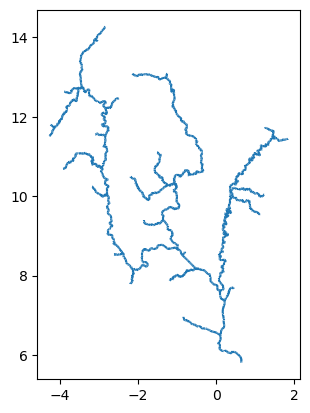

In [16]:
output_river.plot()

In [ ]:
output=False
if output:
main_rivers = gpd.read_file(f"{gis_folder}\\main_rivers_volta.gpkg",crs="epsg:32630")

In [17]:
# output_coefficients_df = []
# for station_index in range(len(names)):
#     # get corresponding names
#     station_name = names[station_index]
#     station_precip = q_p_linking_dictionary[station_name]

#     # do geoanalysis
#     point_discharge = gdf_discharge_client.iloc[station_index].geometry.buffer(0.05)
#     selected_segement =  main_rivers[main_rivers.crosses(point_discharge)]
    
#     if len(selected_segement) < 1:
#         print("no river segment found")
#         # error in finding river segment, we stop
#     else:
#         # get the first segment to enter the buffer around the station
#         selected_location = main_rivers.loc[selected_segement.index[0],:]
#         # retreive the area
#         selected_basin_area = selected_location.UPLAND_SKM* 10**6  # km^2 -> m^2

#         # get precipitation
#         rainfall_selected_basin = Rainfall_BF_msum[[station_precip]].rename(columns={station_precip:"P"})
#         rainfall_selected_basin.P = rainfall_selected_basin.P * selected_basin_area / 1000 # mm/month * m^2 ->/1000 

#         # get evaporation
#         df_local_evaporation = df_temperature_msum[['evap']] * selected_basin_area / 1000 # mm/month * m^2 ->/1000 
#         df_local_evaporation.rename(columns={'evap':'E'},inplace=True)
#         ### do initial compute, but E will be too high
#         combined_df = df_discharge_lst[station_index].copy()
#         combined_df["P"] = rainfall_selected_basin["P"]
#         combined_df["E"] = df_local_evaporation["E"]
#         combined_df["Diff"] = combined_df["P"] - combined_df["Q"] - combined_df["E"]
#         combined_df = combined_df.loc[combined_df.P.dropna().index] # remove lack of Precipitation data
#         # some cases no overlap in data
#         if len(combined_df) > 0:

#             lst_coefficients = []
#             for year in combined_df.index.year.unique():
#                 if len(df_discharge_lst[station_index][f'{year}']) < 10: 
#                     # remove year with too few observations
#                     pass
#                 else:
#                     lst_dfs_fobj_input = [df_discharge_lst[station_index], rainfall_selected_basin, df_local_evaporation]
#                     sol = root(fobj_generalised, 1.2, args=(lst_dfs_fobj_input, year))
#                     lst_coefficients.append(sol.x[0])
# #                     df_fitted= fobj_generalised(sol.x[0], lst_dfs_fobj_input,year, True)
                
                

#             location_lst = [station_name for i in range(len(lst_coefficients))]
#             output_df = pd.DataFrame(columns=['Year',"Factor","Location"],
#                                      data=list(zip(combined_df.index.year.unique(), lst_coefficients, location_lst)))
#             output_df.index.name = station_name
#             output_coefficients_df.append(output_df)
    

In [18]:
# combined_factors = pd.concat(output_coefficients_df)
# combined_factors.sort_values("Year",inplace=True)
# combined_factors.reset_index(inplace=True,drop=True)

In [19]:
# fig, ax = plt.subplots(1)
# ax.plot(combined_factors["Year"].values,combined_factors["Factor"].values,marker='.', lw=0)
# ax.set_ylim(0,0.5)
# # median_factor = combined_factors["Factor"][combined_factors["Factor"]>0.2].median()
# # ax.axhline(median_factor,color="g",alpha=0.3)

# mean_factor = combined_factors["Factor"][combined_factors["Factor"]>0.2].mean()
# ax.axhline(mean_factor,color="r",alpha=0.3)

# ax.set_xlabel("year")
# ax.set_ylabel("Factor Ea of Ep")
# ax.set_title(f"Results from different model fits with {mean_factor}")